In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

**IMPORT THE LIBARARIES**

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import pandas as pd
pd.set_option('display.max_columns',None)
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn import preprocessing,cluster
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.metrics import silhouette_samples,silhouette_score,davies_bouldin_score
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso,LogisticRegression
from xgboost import XGBClassifier

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

import statsmodels as sm
from scipy import stats

from time import time

from imblearn.under_sampling import RandomUnderSampler

from warnings import simplefilter
simplefilter("ignore")

In [3]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [ ]:
data = pd.read_csv('/kaggle/input/expedia-travel-dataset/travel.csv')
data.head()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 100000 non-null  int64  
 1   date_time                  100000 non-null  object 
 2   site_name                  100000 non-null  int64  
 3   posa_continent             100000 non-null  int64  
 4   user_location_country      100000 non-null  int64  
 5   user_location_region       100000 non-null  int64  
 6   user_location_city         100000 non-null  int64  
 7   orig_destination_distance  63915 non-null   float64
 8   user_id                    100000 non-null  int64  
 9   is_mobile                  100000 non-null  int64  
 10  is_package                 100000 non-null  int64  
 11  channel                    100000 non-null  int64  
 12  srch_ci                    99878 non-null   object 
 13  srch_co                    998

In [11]:
data.describe()

,Unnamed: 0,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,63915.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.882530e+07,9.838570,2.678150,85.995070,308.636990,27676.391240,1960.661721,6.054383e+05,0.133770,0.248140,5.858590,2.020710,0.336750,1.111750,14426.32738,2.577290,0.079930,1.487980,3.150920,81.093290,598.848330,49.860370
std,1.086183e+07,11.996426,0.749018,59.292002,208.706581,16768.647409,2228.153377,3.516154e+05,0.340407,0.431936,3.722823,0.909774,0.734449,0.451602,11036.98122,2.149263,0.271186,1.280262,1.620534,56.111519,510.959297,28.885423
min,1.012000e+03,2.000000,0.000000,0.000000,0.000000,0.000000,0.005600,1.400000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.00000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,9.448967e+06,2.000000,3.000000,66.000000,174.000000,12949.000000,312.792100,2.987962e+05,0.000000,0.000000,2.000000,2.000000,0.000000,1.000000,8267.00000,1.000000,0.000000,1.000000,2.000000,50.000000,158.000000,25.000000
50%,1.881212e+07,2.000000,3.000000,66.000000,314.000000,27655.000000,1131.835300,6.028825e+05,0.000000,0.000000,9.000000,2.000000,0.000000,1.000000,9145.00000,1.000000,0.000000,1.000000,2.000000,50.000000,591.000000,49.000000
75%,2.825307e+07,15.000000,3.000000,70.000000,385.000000,42328.000000,2542.359350,9.157222e+05,0.000000,0.000000,9.000000,2.000000,0.000000,1.000000,18784.00000,5.000000,0.000000,2.000000,4.000000,106.000000,701.000000,73.000000
max,3.767009e+07,53.000000,4.000000,239.000000,1025.000000,56507.000000,11965.376100,1.198783e+06,1.000000,1.000000,10.000000,9.000000,9.000000,8.000000,65035.00000,9.000000,1.000000,120.000000,6.000000,212.000000,2117.000000,99.000000


In [22]:
print(f"Unique value in the data:\n\n {data.nunique()}")

Unique value in the data:

 Unnamed: 0                   100000
date_time                     99886
site_name                        41
posa_continent                    5
user_location_country           201
user_location_region            779
user_location_city            10779
orig_destination_distance     62206
user_id                       88863
is_mobile                         2
is_package                        2
channel                          11
srch_ci                        1066
srch_co                        1068
srch_adults_cnt                  10
srch_children_cnt                10
srch_rm_cnt                       9
srch_destination_id            8827
srch_destination_type_id          8
is_booking                        2
cnt                              32
hotel_continent                   7
hotel_country                   178
hotel_market                   1843
hotel_cluster                   100
dtype: int64


In [20]:
print(f"Total duplicate values is {data.duplicated().sum()} in the data")

Total duplicate values is 0 in the data


In [17]:
print(f"Missing values is {data.isnull().sum()} in the data")

Unnamed: 0                       0
date_time                        0
site_name                        0
posa_continent                   0
user_location_country            0
user_location_region             0
user_location_city               0
orig_destination_distance    36085
user_id                          0
is_mobile                        0
is_package                       0
channel                          0
srch_ci                        122
srch_co                        122
srch_adults_cnt                  0
srch_children_cnt                0
srch_rm_cnt                      0
srch_destination_id              0
srch_destination_type_id         0
is_booking                       0
cnt                              0
hotel_continent                  0
hotel_country                    0
hotel_market                     0
hotel_cluster                    0
dtype: int64

In [19]:
print(f"Total missing values is {data.isnull().sum().sum()} in the data")

Total missing values is 36329 in the data


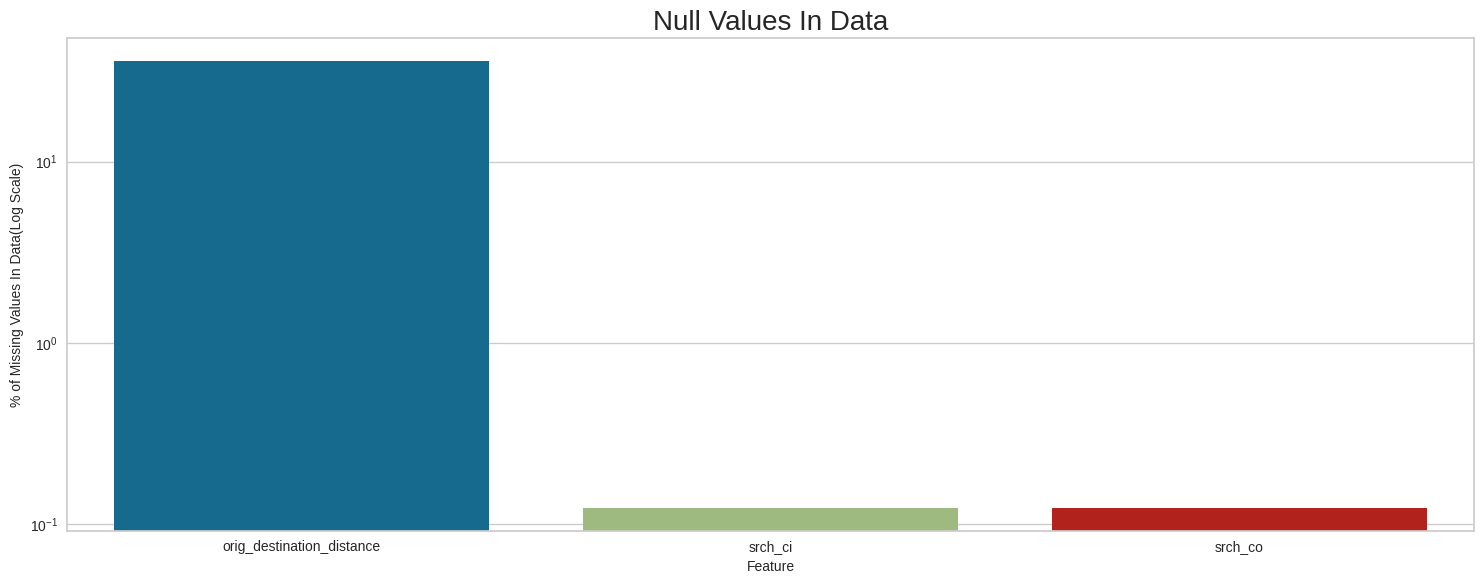

In [24]:
def null_values(data,title,x_label,y_label):
    null_data=(data.apply(lambda x : x.isnull().value_counts()).T[True]/len(data)*100).reset_index(name="count")
    plt.figure(figsize=(15,6))
    sns.barplot(null_data[null_data['count']>0],x='index',y='count')
    plt.yscale('log')
    plt.title(title,fontsize=20)
    plt.xlabel(x_label,fontsize=10)
    plt.ylabel(y_label,fontsize=10)
    plt.tight_layout()
    plt.show()

null_values(data,"Null Values In Data","Feature","% of Missing Values In Data(Log Scale)")

**CORRELATION MATRIX**

In [27]:
corr_mat=data.drop(['Unnamed: 0','date_time','srch_ci','srch_co'],axis=1)
plt.figure(figsize=(15,15))
plt.corr
plt.title("Correlation Matrix")
plt.show()